In [51]:
#|default_exp tmp

# Resnet18d working

In [1]:
#| export
import pickle,gzip,math,os,time,shutil,torch,random
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torchvision import transforms
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
from miniai.challange.ct94ep5 import *
from miniai.utils import *
from miniai.accel import *
import timm

In [2]:
from miniai.challange.base import *

In [3]:
import dadaptation

In [4]:
tds = setup_fasion_mnist()

Reseed: 1


  0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
import miniai.challange.base
miniai.challange.base.tds = tds

In [3]:
run = partial(run, leaky=0.0, train_cb=MixedPrecision(), epochs=5, base_lr=2e-2, loss_func=F.cross_entropy, bs=256, sched_fn=lr_scheduler.OneCycleLR, opt_func=optim.AdamW, tds=tds.cached)

In [6]:
upscale32 = Upscale(28, align=True, const=-0.800000011920929)

Reseed: 1
Reseed: 1
Batch size 1024
Reseed: 1


accuracy,loss,epoch,train
0.821,0.701,0,train
0.851,0.470,0,eval
0.887,0.363,1,train
0.880,0.349,1,eval
0.913,0.261,2,train
0.902,0.280,2,eval
0.931,0.205,3,train
0.919,0.232,3,eval
0.949,0.155,4,train
0.924,0.221,4,eval


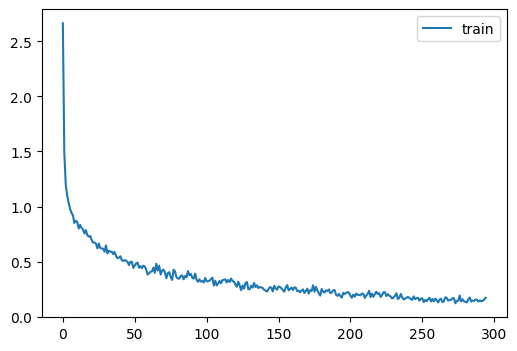

Fit 5 in: 13.69s, setup: 0.00s, 2.59 ± 0.10s per epoch, 0.01 ± 0.00s per batch


In [12]:

learn = run(**model_base_resnet(), bs=1024, base_lr=2e-2, train_cb=TrainCB())

In [8]:
RNG.previous()
learn = run(model=get_model(), epochs=1)
xb,yb = learn.batch

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.795,0.580,0,train
0.859,0.375,0,eval


Fit 1 in: 1.23s, setup: 0.01s, 1.18 ± 0.00s per epoch, 0.00 ± 0.00s per batch


In [12]:
xb.shape, upscale32.bilinear(4)(xb).shape,upscale32.pad(4)(xb).shape

(torch.Size([272, 1, 28, 28]),
 torch.Size([272, 1, 128, 128]),
 torch.Size([272, 1, 128, 128]))

In [13]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2)), leaky=0.0, epochs=1)

Reseed: 1
duplicate key leaky 
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.848,0.430,0,train
0.911,0.240,0,eval


Fit 1 in: 6.87s, setup: 0.00s, 6.63 ± 0.00s per epoch, 0.03 ± 0.01s per batch


### Resnet with augment & curriculum learning

In [ ]:
xb[0,0,0,0].item()

-0.800000011920929

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.810,0.536,0,train
0.870,0.365,0,eval
0.889,0.302,1,train
0.873,0.366,1,eval
0.913,0.235,2,train
0.916,0.234,2,eval
0.933,0.182,3,train
0.936,0.184,3,eval
0.948,0.141,4,train
0.941,0.171,4,eval


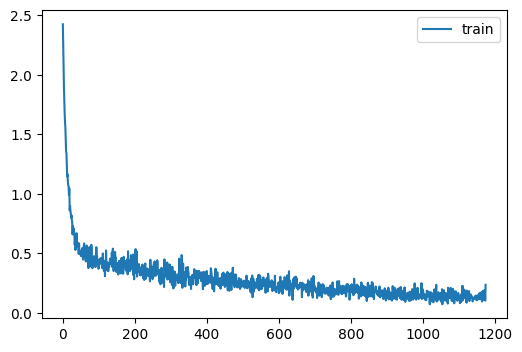

Fit 5 in: 34.30s, setup: 0.00s, 6.54 ± 0.05s per epoch, 0.03 ± 0.00s per batch


In [14]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0), get_augcb(transforms.RandomCrop(28, padding=1, fill=-0.800000011920929)))

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.803,0.549,0,train
0.807,0.734,0,eval
0.872,0.352,1,train
0.883,0.345,1,eval
0.902,0.271,2,train
0.905,0.266,2,eval
0.923,0.211,3,train
0.927,0.209,3,eval
0.938,0.167,4,train
0.936,0.184,4,eval


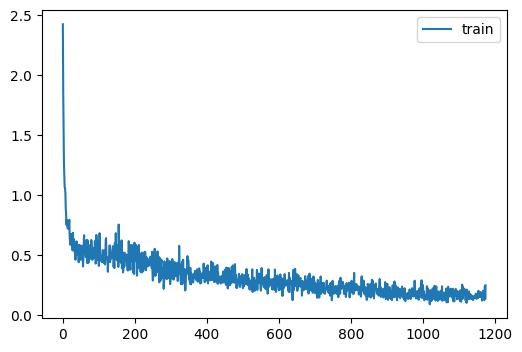

Fit 5 in: 82.14s, setup: 0.00s, 15.70 ± 0.16s per epoch, 0.06 ± 0.01s per batch


In [19]:
learn = run(timm_model('resnet50d', upscale32.bilinear(2), leaky=0.0, drop_rate=.4), get_augcb(transforms.RandomCrop(28, padding=1, fill=-0.800000011920929)))

In [17]:
# Mixup select

In [26]:
import dadaptation

In [27]:
def dadapt_adam():return dict(opt_func=partial(dadaptation.DAdaptAdam, weight_decay=0.0), base_lr=1,)

### 94.95% Mixup 0.4 no lbl smooth

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.538,1.462,0,train
0.855,0.414,0,eval
0.781,0.871,1,train
0.864,0.372,1,eval
0.801,0.798,2,train
0.876,0.364,2,eval
0.816,0.747,3,train
0.862,0.390,3,eval
0.818,0.731,4,train
0.884,0.323,4,eval


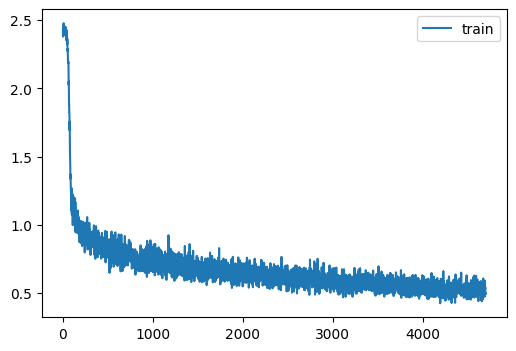

Fit 20 in: 225.12s, setup: 0.00s, 10.93 ± 0.09s per epoch, 0.04 ± 0.00s per batch
Reseed: 1
Reseed: 1
TTA: 0.9495


In [28]:

learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.2)),
            dadapt_adam(),
            train_cb=MixUpFP16CB(0.4, use_prev=True, label_smoothing=0.0),
            epochs=20, tta=True)

### 95.06% Mixup 0.1 no lbl smooth

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.569,1.274,0,train
0.787,0.624,0,eval
0.827,0.610,1,train
0.877,0.354,1,eval
0.846,0.559,2,train
0.875,0.364,2,eval
0.859,0.514,3,train
0.870,0.374,3,eval
0.868,0.486,4,train
0.893,0.341,4,eval


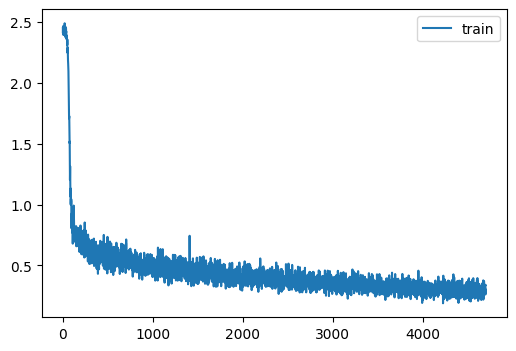

Fit 20 in: 224.71s, setup: 0.00s, 10.92 ± 0.07s per epoch, 0.04 ± 0.00s per batch
Reseed: 1
Reseed: 1
TTA: 0.9506


In [29]:

learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.2)),
            dadapt_adam(),
            train_cb=MixUpFP16CB(0.1, use_prev=True, label_smoothing=0.0),
            epochs=20, tta=True)

### 94.83% Mixup 0.1 lbl smoothing 0.1

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.572,1.501,0,train
0.818,0.541,0,eval
0.829,0.982,1,train
0.879,0.395,1,eval
0.851,0.931,2,train
0.868,0.445,2,eval
0.864,0.895,3,train
0.881,0.425,3,eval
0.872,0.879,4,train
0.888,0.380,4,eval


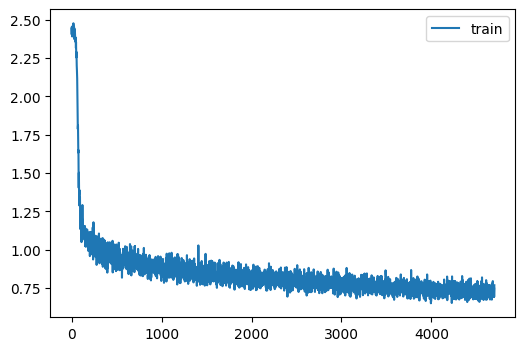

Fit 20 in: 226.23s, setup: 0.00s, 10.99 ± 0.06s per epoch, 0.04 ± 0.00s per batch
Reseed: 1
Reseed: 1
TTA: 0.9483


In [30]:

learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.2)),
            dadapt_adam(),
            train_cb=MixUpFP16CB(0.1, use_prev=True, label_smoothing=0.1),
            epochs=20, tta=True)

## Batch size 20ep 95.06% 256 - 226.23

### 94.27% 2k - 100s

Reseed: 1
Batch size 2048
Reseed: 1


accuracy,loss,epoch,train
0.086,2.422,0,train
0.142,2.262,0,eval
0.605,1.227,1,train
0.550,3.230,1,eval
0.784,0.731,2,train
0.762,0.708,2,eval
0.817,0.628,3,train
0.810,0.618,3,eval
0.829,0.598,4,train
0.852,0.409,4,eval


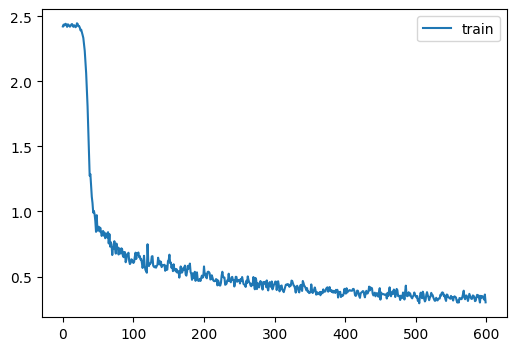

Fit 20 in: 102.16s, setup: 0.00s, 4.82 ± 0.05s per epoch, 0.15 ± 0.02s per batch
Reseed: 1
Reseed: 1
TTA: 0.9427


In [37]:

learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.2)),
            dadapt_adam(),
            train_cb=MixUpFP16CB(0.1, use_prev=True, label_smoothing=0.0),
            epochs=20, bs=2048, tta=True)

### 94.75% 1k - 119s

Reseed: 1
Batch size 1024
Reseed: 1


accuracy,loss,epoch,train
0.226,2.127,0,train
0.343,3.453,0,eval
0.768,0.756,1,train
0.766,0.659,1,eval
0.820,0.627,2,train
0.853,0.434,2,eval
0.839,0.568,3,train
0.857,0.435,3,eval
0.856,0.520,4,train
0.900,0.297,4,eval


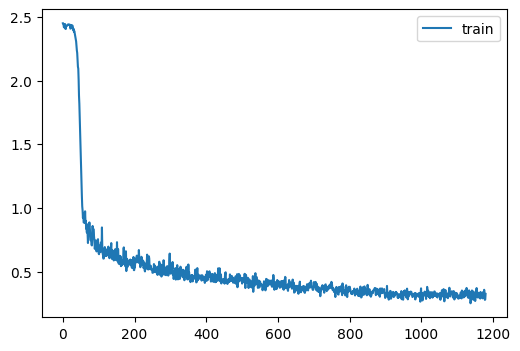

Fit 20 in: 119.45s, setup: 0.00s, 5.68 ± 0.08s per epoch, 0.09 ± 0.01s per batch
Reseed: 1
Reseed: 1
TTA: 0.9475


In [34]:

learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.2)),
            dadapt_adam(),
            train_cb=MixUpFP16CB(0.1, use_prev=True, label_smoothing=0.0),
            epochs=20, bs=1024, tta=True)

### 94.71% 0.5k - 155s

Reseed: 1
Batch size 512
Reseed: 1


accuracy,loss,epoch,train
0.427,1.627,0,train
0.748,0.790,0,eval
0.815,0.644,1,train
0.834,0.503,1,eval
0.836,0.580,2,train
0.830,0.470,2,eval
0.853,0.529,3,train
0.878,0.391,3,eval
0.862,0.501,4,train
0.892,0.325,4,eval


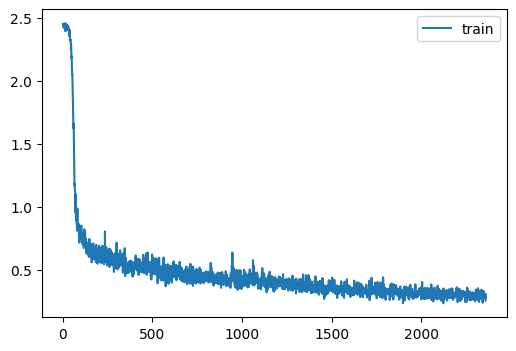

Fit 20 in: 155.07s, setup: 0.00s, 7.46 ± 0.05s per epoch, 0.06 ± 0.00s per batch
Reseed: 1
Reseed: 1
TTA: 0.9471


In [36]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.2)),
            dadapt_adam(),
            train_cb=MixUpFP16CB(0.1, use_prev=True, label_smoothing=0.0),
            epochs=20, bs=512, tta=True)

## Batch size 50 epochs

### 95.22% 50epochs 2k 255.38s

Reseed: 1
Batch size 2048
Reseed: 1


accuracy,loss,epoch,train
0.083,2.429,0,train
0.067,2.375,0,eval
0.353,1.875,1,train
0.595,1.551,1,eval
0.764,0.778,2,train
0.692,1.482,2,eval
0.810,0.647,3,train
0.771,0.812,3,eval
0.831,0.594,4,train
0.845,0.412,4,eval


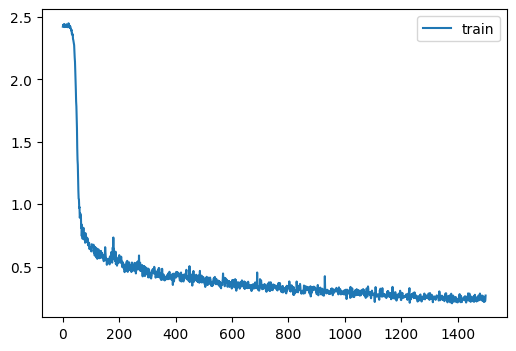

Fit 50 in: 255.38s, setup: 0.00s, 4.82 ± 0.03s per epoch, 0.15 ± 0.02s per batch
Reseed: 1
Reseed: 1
TTA: 0.9522


In [38]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.2)),
            dadapt_adam(),
            train_cb=MixUpFP16CB(0.1, use_prev=True, label_smoothing=0.0),
            epochs=50, bs=2048, tta=True)

### 95.57% 50epochs 256 563.60s

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.564,1.294,0,train
0.840,0.447,0,eval
0.829,0.600,1,train
0.885,0.316,1,eval
0.850,0.542,2,train
0.881,0.337,2,eval
0.864,0.500,3,train
0.896,0.321,3,eval
0.863,0.493,4,train
0.905,0.274,4,eval


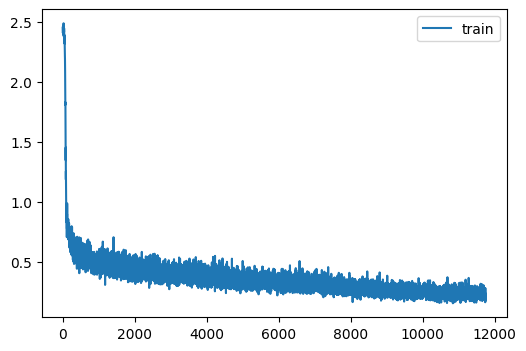

Fit 50 in: 563.60s, setup: 0.00s, 10.95 ± 0.08s per epoch, 0.04 ± 0.00s per batch
Reseed: 1
Reseed: 1
TTA: 0.9557


In [39]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.2)),
            dadapt_adam(),
            train_cb=MixUpFP16CB(0.1, use_prev=True, label_smoothing=0.0),
            epochs=50, bs=256, tta=True)

In [18]:
MixUpFP16CB

miniai.challange.base.MixUpFP16CB

# Laion

In [45]:
# copy from google repo
from torch.optim.optimizer import Optimizer


class Lion(Optimizer):
  r"""Implements Lion algorithm."""

  def __init__(self, params, lr=1e-4, betas=(0.9, 0.99), weight_decay=0.0):
    """Initialize the hyperparameters.
    Args:
      params (iterable): iterable of parameters to optimize or dicts defining
        parameter groups
      lr (float, optional): learning rate (default: 1e-4)
      betas (Tuple[float, float], optional): coefficients used for computing
        running averages of gradient and its square (default: (0.9, 0.99))
      weight_decay (float, optional): weight decay coefficient (default: 0)
    """

    if not 0.0 <= lr:
      raise ValueError('Invalid learning rate: {}'.format(lr))
    if not 0.0 <= betas[0] < 1.0:
      raise ValueError('Invalid beta parameter at index 0: {}'.format(betas[0]))
    if not 0.0 <= betas[1] < 1.0:
      raise ValueError('Invalid beta parameter at index 1: {}'.format(betas[1]))
    defaults = dict(lr=lr, betas=betas, weight_decay=weight_decay)
    super().__init__(params, defaults)

  @torch.no_grad()
  def step(self, closure=None):
    """Performs a single optimization step.
    Args:
      closure (callable, optional): A closure that reevaluates the model
        and returns the loss.
    Returns:
      the loss.
    """
    loss = None
    if closure is not None:
      with torch.enable_grad():
        loss = closure()

    for group in self.param_groups:
      for p in group['params']:
        if p.grad is None:
          continue

        # Perform stepweight decay
        p.data.mul_(1 - group['lr'] * group['weight_decay'])

        grad = p.grad
        state = self.state[p]
        # State initialization
        if len(state) == 0:
          # Exponential moving average of gradient values
          state['exp_avg'] = torch.zeros_like(p)

        exp_avg = state['exp_avg']
        beta1, beta2 = group['betas']

        # Weight update
        update = exp_avg * beta1 + grad * (1 - beta1)
        p.add_(torch.sign(update), alpha=-group['lr'])
        # Decay the momentum running average coefficient
        exp_avg.mul_(beta2).add_(grad, alpha=1 - beta2)

    return loss

In [ ]:
## Lr for liaon

In [50]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.2)),
            opt_func=Lion,
            train_cb=MixUpFP16CB(0.1, use_prev=True, label_smoothing=0.0),
            epochs=50, bs=2048, base_lr=2e-2/10, tta=True, fit=False)

Reseed: 1
Batch size 2048
Reseed: 1
{'accuracy': '0.100', 'loss': '2.381', 'epoch': 0, 'train': 'eval'}
Reseed: 1
{'accuracy': '0.100', 'loss': '2.381', 'epoch': 0, 'train': 'eval'}
TTA: 0.1


In [54]:
del learn.cbs[3]

In [55]:
learn.cbs+=[ProgressCB()]

Reseed: 1


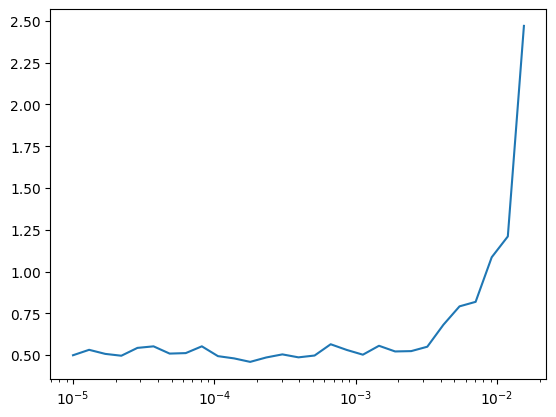

In [56]:
learn.lr_find()

## 95.16% bs=2048, 2e-3 (227.53s)

Reseed: 1
Batch size 2048
Reseed: 1


accuracy,loss,epoch,train
0.252,2.157,0,train
0.456,1.844,0,eval
0.475,1.685,1,train
0.638,1.206,1,eval
0.610,1.292,2,train
0.721,0.843,2,eval
0.701,0.998,3,train
0.737,0.731,3,eval
0.764,0.794,4,train
0.803,0.585,4,eval


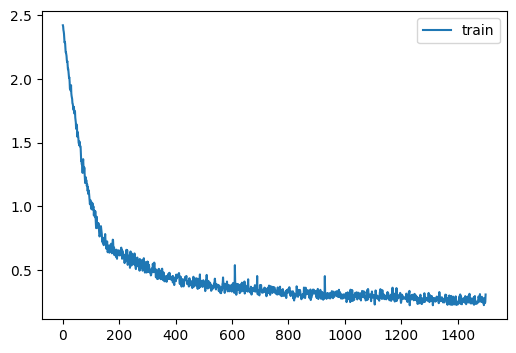

Fit 50 in: 227.53s, setup: 0.00s, 4.26 ± 0.04s per epoch, 0.13 ± 0.02s per batch
Reseed: 1
Reseed: 1
TTA: 0.9516


In [48]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.2)),
            opt_func=Lion,
            train_cb=MixUpFP16CB(0.1, use_prev=True, label_smoothing=0.0),
            epochs=50, bs=2048, base_lr=2e-2/10, tta=True)

Reseed: 1
Batch size 2048
Reseed: 1


accuracy,loss,epoch,train
0.162,2.281,0,train
0.349,2.088,0,eval
0.373,1.973,1,train
0.523,1.626,1,eval
0.478,1.653,2,train
0.642,1.221,2,eval
0.592,1.333,3,train
0.716,0.921,3,eval
0.677,1.085,4,train
0.744,0.713,4,eval


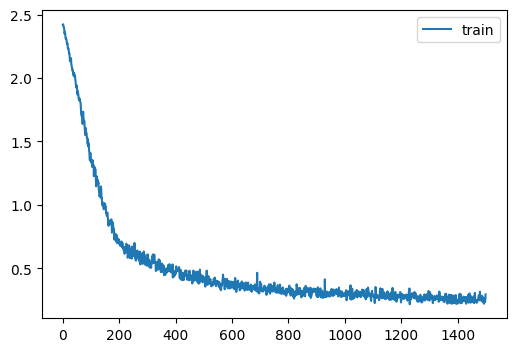

Fit 50 in: 228.14s, setup: 0.00s, 4.27 ± 0.04s per epoch, 0.13 ± 0.02s per batch
Reseed: 1
Reseed: 1
TTA: 0.951


In [57]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.2)),
            opt_func=Lion,
            train_cb=MixUpFP16CB(0.1, use_prev=True, label_smoothing=0.0),
            epochs=50, bs=2048, base_lr=1e-2/10, tta=True)

Reseed: 1
Batch size 2048
Reseed: 1


accuracy,loss,epoch,train
0.156,2.294,0,train
0.312,2.088,0,eval
0.351,2.023,1,train
0.513,1.623,1,eval
0.445,1.766,2,train
0.640,1.209,2,eval
0.558,1.503,3,train
0.707,0.921,3,eval
0.646,1.311,4,train
0.740,0.737,4,eval


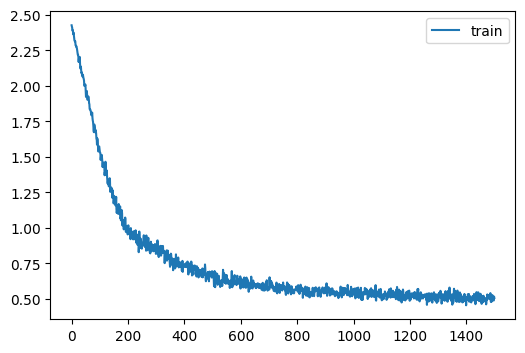

Fit 50 in: 229.91s, setup: 0.00s, 4.30 ± 0.03s per epoch, 0.13 ± 0.02s per batch
Reseed: 1
Reseed: 1
TTA: 0.9508


In [58]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.2)),
            opt_func=Lion,
            train_cb=MixUpFP16CB(0.4, use_prev=True, label_smoothing=0.0),
            epochs=50, bs=2048, base_lr=1e-2/10, tta=True)

Reseed: 1
Batch size 2048
Reseed: 1


accuracy,loss,epoch,train
0.156,2.301,0,train
0.315,2.088,0,eval
0.350,2.062,1,train
0.519,1.625,1,eval
0.447,1.850,2,train
0.644,1.209,2,eval
0.565,1.654,3,train
0.715,0.925,3,eval
0.651,1.517,4,train
0.737,0.806,4,eval


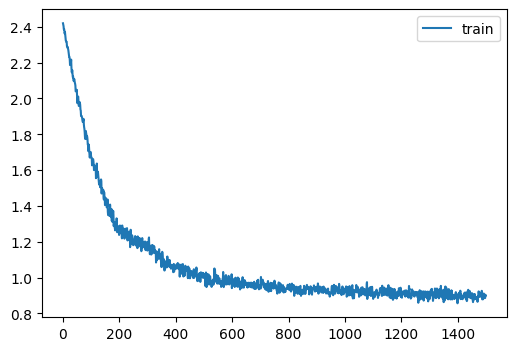

Fit 50 in: 229.87s, setup: 0.00s, 4.30 ± 0.04s per epoch, 0.13 ± 0.02s per batch
Reseed: 1
Reseed: 1
TTA: 0.9527


In [59]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.2)),
            opt_func=Lion,
            train_cb=MixUpFP16CB(0.4, use_prev=True, label_smoothing=0.1),
            epochs=50, bs=2048, base_lr=1e-2/10, tta=True)

## ??% bs=512 1e-2 adamW (285.39s) resnet18d

Reseed: 205811062
Batch size 512
Reseed: 205811062


accuracy,loss,epoch,train
0.621,1.537,0,train
0.812,0.551,0,eval
0.777,1.221,1,train
0.859,0.470,1,eval
0.804,1.149,2,train
0.881,0.419,2,eval
0.816,1.113,3,train
0.882,0.415,3,eval
0.821,1.099,4,train
0.881,0.411,4,eval


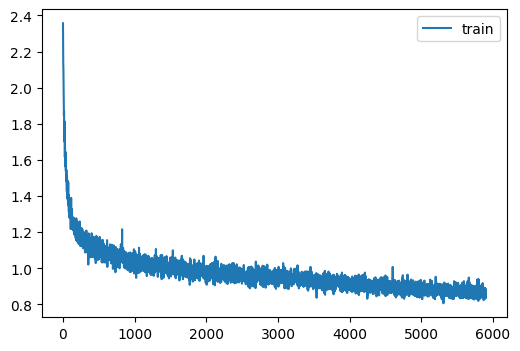

Fit 50 in: 293.75s, setup: 0.00s, 5.57 ± 0.14s per epoch, 0.04 ± 0.01s per batch
Reseed: 205811062
Reseed: 205811062
TTA: 0.9544


In [9]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.2)),
            #opt_func=Lion,
            train_cb=MixUpFP16CB(0.4, use_prev=True, label_smoothing=0.1),
            epochs=50, bs=512, base_lr=1e-2, tta=True)

## 95.78% bs=512 1e-3 (285.39s) resnet18d

Reseed: 1
Batch size 512
Reseed: 1


accuracy,loss,epoch,train
0.329,2.058,0,train
0.617,1.335,0,eval
0.580,1.632,1,train
0.737,0.825,1,eval
0.709,1.383,2,train
0.821,0.541,2,eval
0.778,1.218,3,train
0.868,0.415,3,eval
0.807,1.139,4,train
0.891,0.359,4,eval


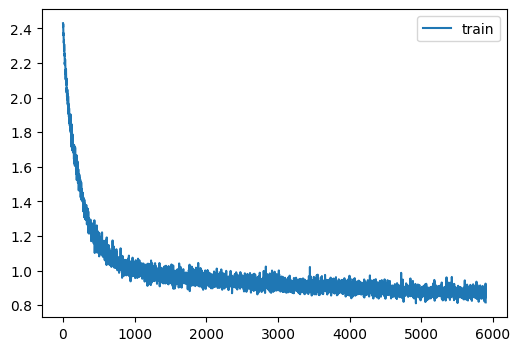

Fit 50 in: 285.39s, setup: 0.00s, 5.40 ± 0.05s per epoch, 0.04 ± 0.00s per batch
Reseed: 1
Reseed: 1
TTA: 0.9578


In [61]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.2)),
            opt_func=Lion,
            train_cb=MixUpFP16CB(0.4, use_prev=True, label_smoothing=0.1),
            epochs=50, bs=512, base_lr=1e-3, tta=True)

### 95.39% no lblsmooth

Reseed: 1
Batch size 512
Reseed: 1


accuracy,loss,epoch,train
0.328,2.014,0,train
0.605,1.335,0,eval
0.573,1.479,1,train
0.728,0.820,1,eval
0.702,1.151,2,train
0.815,0.506,2,eval
0.772,0.926,3,train
0.867,0.372,3,eval
0.797,0.827,4,train
0.892,0.308,4,eval


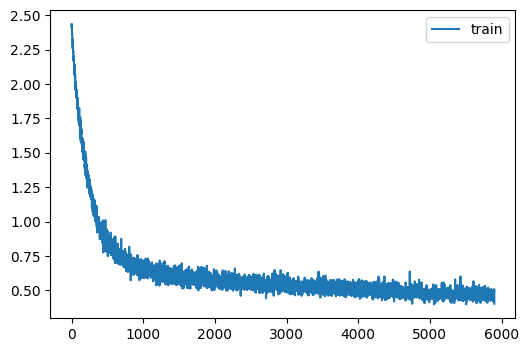

Fit 50 in: 285.35s, setup: 0.00s, 5.40 ± 0.03s per epoch, 0.04 ± 0.00s per batch
Reseed: 1
Reseed: 1
TTA: 0.9539


In [68]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.2)),
            opt_func=Lion,
            train_cb=MixUpFP16CB(0.4, use_prev=True, label_smoothing=0.0),
            epochs=50, bs=512, base_lr=1e-3, tta=True)

### 95.53% drop_rate=0.5

Reseed: 1
Batch size 512
Reseed: 1


accuracy,loss,epoch,train
0.311,2.073,0,train
0.615,1.338,0,eval
0.564,1.647,1,train
0.735,0.832,1,eval
0.699,1.400,2,train
0.819,0.547,2,eval
0.772,1.232,3,train
0.867,0.419,3,eval
0.804,1.147,4,train
0.892,0.357,4,eval


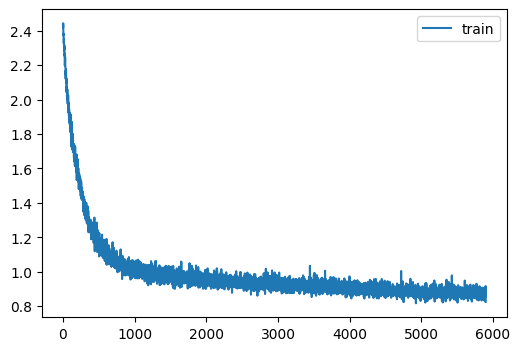

Fit 50 in: 285.24s, setup: 0.00s, 5.40 ± 0.06s per epoch, 0.04 ± 0.00s per batch
Reseed: 1
Reseed: 1
TTA: 0.9553


In [66]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.5),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.2)),
            opt_func=Lion,
            train_cb=MixUpFP16CB(0.4, use_prev=True, label_smoothing=0.1),
            epochs=50, bs=512, base_lr=1e-3, tta=True)

### 95.31% RandErase 0.3

Reseed: 1
Batch size 512
Reseed: 1


accuracy,loss,epoch,train
0.298,2.091,0,train
0.585,1.355,0,eval
0.534,1.685,1,train
0.718,0.854,1,eval
0.671,1.445,2,train
0.804,0.576,2,eval
0.746,1.279,3,train
0.842,0.471,3,eval
0.780,1.197,4,train
0.883,0.371,4,eval


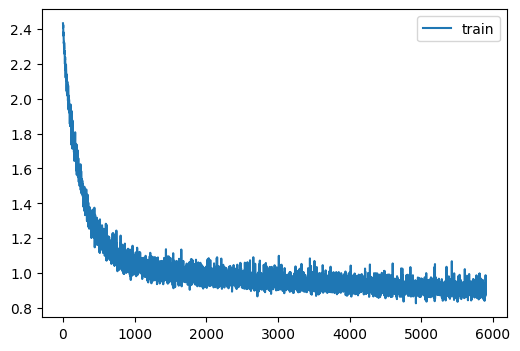

Fit 50 in: 285.96s, setup: 0.00s, 5.41 ± 0.03s per epoch, 0.04 ± 0.00s per batch
Reseed: 1
Reseed: 1
TTA: 0.9531


In [67]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.3)),
            opt_func=Lion,
            train_cb=MixUpFP16CB(0.4, use_prev=True, label_smoothing=0.1),
            epochs=50, bs=512, base_lr=1e-3, tta=True)

### 95.61% drop_rate 0.2

Reseed: 1
Batch size 512
Reseed: 1


accuracy,loss,epoch,train
0.323,2.072,0,train
0.593,1.349,0,eval
0.559,1.665,1,train
0.718,0.848,1,eval
0.684,1.424,2,train
0.809,0.570,2,eval
0.756,1.256,3,train
0.854,0.452,3,eval
0.783,1.184,4,train
0.883,0.378,4,eval


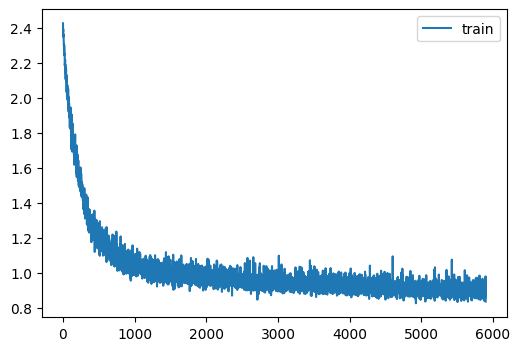

Fit 50 in: 286.12s, setup: 0.00s, 5.41 ± 0.02s per epoch, 0.04 ± 0.00s per batch
Reseed: 1
Reseed: 1
TTA: 0.9561


In [74]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.2),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.3)),
            opt_func=Lion,
            train_cb=MixUpFP16CB(0.4, use_prev=True, label_smoothing=0.1),
            epochs=50, bs=512, base_lr=1e-3, tta=True)

### 95.64% MixUp 0.5

Reseed: 1
Batch size 512
Reseed: 1


accuracy,loss,epoch,train
0.326,2.066,0,train
0.630,1.326,0,eval
0.580,1.653,1,train
0.737,0.821,1,eval
0.701,1.413,2,train
0.815,0.565,2,eval
0.769,1.252,3,train
0.868,0.414,3,eval
0.797,1.174,4,train
0.882,0.399,4,eval


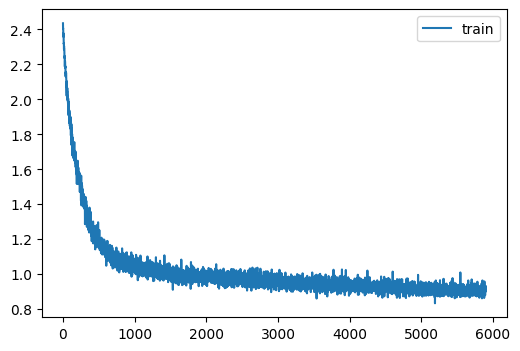

Fit 50 in: 286.34s, setup: 0.00s, 5.42 ± 0.02s per epoch, 0.04 ± 0.00s per batch
Reseed: 1
Reseed: 1
TTA: 0.9564


In [72]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.2)),
            opt_func=Lion,
            train_cb=MixUpFP16CB(0.5, use_prev=True, label_smoothing=0.1),
            epochs=50, bs=512, base_lr=1e-3, tta=True)

### 95.51% MixUp 0.3

Reseed: 1
Batch size 512
Reseed: 1


accuracy,loss,epoch,train
0.334,2.044,0,train
0.629,1.329,0,eval
0.597,1.590,1,train
0.727,0.837,1,eval
0.715,1.339,2,train
0.830,0.538,2,eval
0.786,1.174,3,train
0.872,0.392,3,eval
0.822,1.090,4,train
0.883,0.381,4,eval


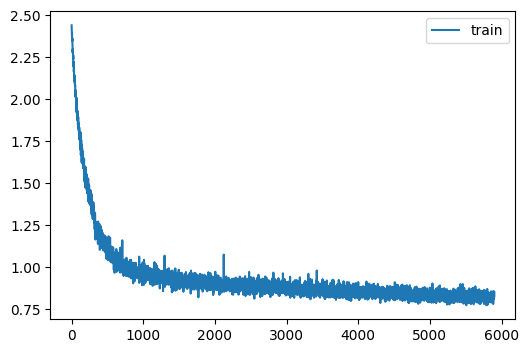

Fit 50 in: 285.70s, setup: 0.00s, 5.41 ± 0.02s per epoch, 0.04 ± 0.00s per batch
Reseed: 1
Reseed: 1
TTA: 0.9551


In [78]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.2)),
            opt_func=Lion,
            train_cb=MixUpFP16CB(0.3, use_prev=True, label_smoothing=0.1),
            epochs=50, bs=512, base_lr=1e-3, tta=True)

### BS 1024 lr 2e-3

Reseed: 1
Batch size 1024
Reseed: 1


accuracy,loss,epoch,train
0.328,2.058,0,train
0.608,1.340,0,eval
0.569,1.647,1,train
0.731,0.847,1,eval
0.693,1.423,2,train
0.787,0.629,2,eval
0.762,1.259,3,train
0.826,0.514,3,eval
0.784,1.193,4,train
0.861,0.431,4,eval


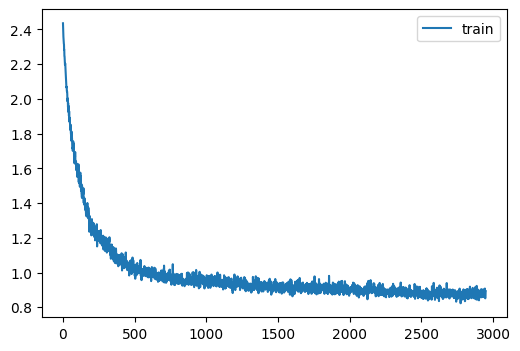

Fit 50 in: 247.86s, setup: 0.00s, 4.66 ± 0.06s per epoch, 0.07 ± 0.01s per batch
Reseed: 1
Reseed: 1
TTA: 0.9552


In [79]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.2)),
            opt_func=Lion,
            train_cb=MixUpFP16CB(0.4, use_prev=True, label_smoothing=0.1),
            epochs=50, bs=1024, base_lr=2e-3, tta=True)

## 20ep - 94.84% bs=512 1e-3

Reseed: 1
Batch size 512
Reseed: 1


accuracy,loss,epoch,train
0.347,2.023,0,train
0.672,1.140,0,eval
0.656,1.488,1,train
0.802,0.568,1,eval
0.772,1.233,2,train
0.878,0.379,2,eval
0.808,1.133,3,train
0.889,0.370,3,eval
0.831,1.065,4,train
0.907,0.322,4,eval


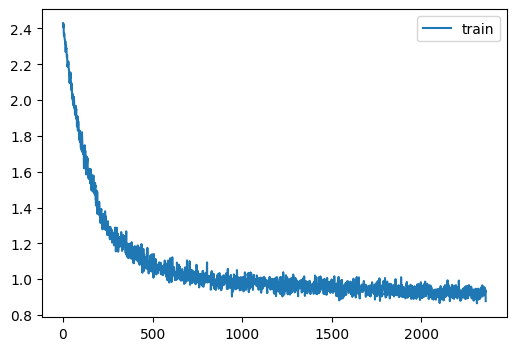

Fit 20 in: 114.08s, setup: 0.00s, 5.41 ± 0.02s per epoch, 0.04 ± 0.00s per batch
Reseed: 1
Reseed: 1
TTA: 0.9484


In [64]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.2)),
            opt_func=Lion,
            train_cb=MixUpFP16CB(0.4, use_prev=True, label_smoothing=0.1),
            epochs=20, bs=512, base_lr=1e-2/10, tta=True)

## 50 ep on resnet50d

### 95.55% bs=256 1e-3 Lion

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.595,1.569,0,train
0.809,0.572,0,eval
0.766,1.237,1,train
0.865,0.441,1,eval
0.804,1.134,2,train
0.887,0.383,2,eval
0.827,1.079,3,train
0.898,0.371,3,eval
0.835,1.054,4,train
0.911,0.322,4,eval


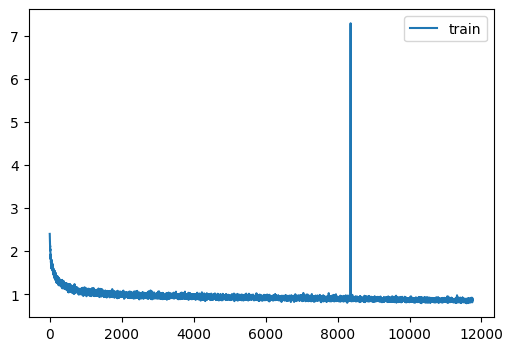

Fit 50 in: 814.58s, setup: 0.00s, 15.53 ± 0.05s per epoch, 0.06 ± 0.00s per batch
Reseed: 1
Reseed: 1
TTA: 0.9555


In [60]:
learn = run(timm_model('resnet50d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                upscale32.bilinear(2),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.2)),
            train_cb=MixUpFP16CB(0.4, use_prev=True, label_smoothing=0.1),
            opt_func=Lion, base_lr=1e-3,
            epochs=50, tta=True)

### 95.74% bs=512 1e-3 Lion

Reseed: 1
Batch size 512
Reseed: 1


accuracy,loss,epoch,train
0.508,1.727,0,train
0.745,0.732,0,eval
0.706,1.367,1,train
0.796,0.584,1,eval
0.773,1.222,2,train
0.860,0.450,2,eval
0.805,1.134,3,train
0.877,0.402,3,eval
0.823,1.087,4,train
0.888,0.365,4,eval


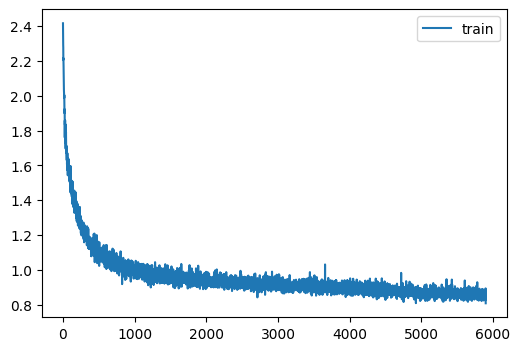

Fit 50 in: 676.93s, setup: 0.00s, 12.82 ± 0.06s per epoch, 0.10 ± 0.01s per batch
Reseed: 1
Reseed: 1
TTA: 0.9574


In [62]:
# Can i get around the peak in loss using larger bs?
learn = run(timm_model('resnet50d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                upscale32.bilinear(2),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.2)),
            train_cb=MixUpFP16CB(0.4, use_prev=True, label_smoothing=0.1),
            opt_func=Lion, base_lr=1e-2/10, bs=512,
            epochs=50, tta=True)

### 95.56% bs=256 2e-2 AdamW

Reseed: 1
Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.714,1.341,0,train
0.852,0.469,0,eval
0.789,1.173,1,train
0.868,0.418,1,eval
0.808,1.125,2,train
0.877,0.421,2,eval
0.820,1.092,3,train
0.899,0.435,3,eval
0.826,1.074,4,train
0.887,0.408,4,eval


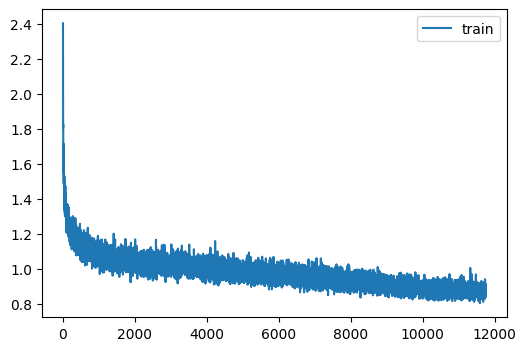

Fit 50 in: 852.79s, setup: 0.00s, 16.29 ± 0.14s per epoch, 0.07 ± 0.01s per batch
Reseed: 1
Reseed: 1
TTA: 0.9556


In [6]:
RNG.set_seed(1)
learn = run(timm_model('resnet50d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                upscale32.bilinear(2),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.2)),
            train_cb=MixUpFP16CB(0.4, use_prev=True, label_smoothing=0.1),
            opt_func=partial(optim.AdamW, weight_decay=0.0), base_lr=2e-2,
            epochs=50, tta=True)

### 95.56% bs=256 2e-2 AdamW

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.714,1.341,0,train
0.851,0.472,0,eval
0.789,1.173,1,train
0.870,0.412,1,eval
0.807,1.124,2,train
0.871,0.435,2,eval
0.820,1.094,3,train
0.898,0.404,3,eval
0.825,1.076,4,train
0.886,0.395,4,eval


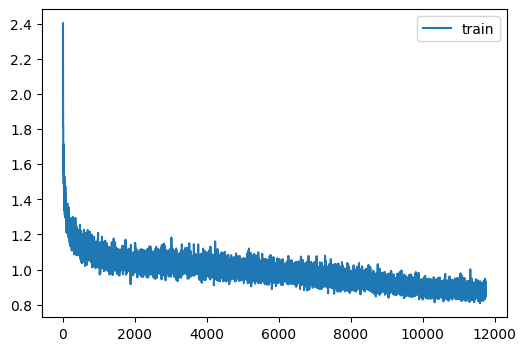

Fit 50 in: 851.19s, setup: 0.00s, 16.26 ± 0.04s per epoch, 0.07 ± 0.00s per batch
Reseed: 1
Reseed: 1
TTA: 0.9556


In [7]:
learn = run(timm_model('resnet50d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                upscale32.bilinear(2),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.2)),
            train_cb=MixUpFP16CB(0.4, use_prev=True, label_smoothing=0.1),
            base_lr=2e-2,
            epochs=50, tta=True)

### 95.54RandErase 0.15 AdamW

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.725,1.314,0,train
0.850,0.482,0,eval
0.796,1.156,1,train
0.875,0.430,1,eval
0.813,1.109,2,train
0.886,0.401,2,eval
0.828,1.075,3,train
0.869,0.478,3,eval
0.829,1.062,4,train
0.881,0.434,4,eval


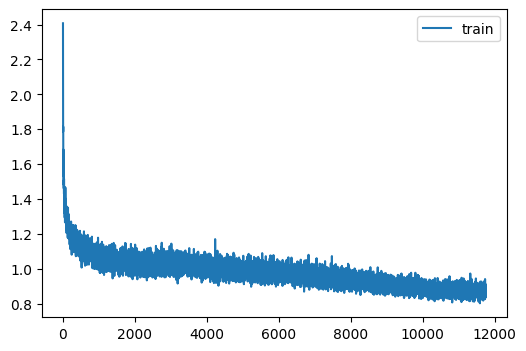

Fit 50 in: 852.27s, setup: 0.00s, 16.28 ± 0.04s per epoch, 0.07 ± 0.00s per batch
Reseed: 1
Reseed: 1
TTA: 0.9554


In [8]:
learn = run(timm_model('resnet50d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                upscale32.bilinear(2),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.15)),
            train_cb=MixUpFP16CB(0.4, use_prev=True, label_smoothing=0.1),
            base_lr=2e-2,
            epochs=50, tta=True)

In [9]:
def save_model(learn, name):
    from accelerate import Accelerator
    mdl_path = Path.home()/"models"/"fmnist"
    mdl_path.mkdir(parents=True,exist_ok=True)
    model=learn.cbs[-1].acc.unwrap_model(learn.model)
    state_dict = model.state_dict()
    learn.cbs[-1].acc.save(state_dict,  mdl_path/name)

### 95.55 RandErase DAapt 

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.494,1.721,0,train
0.813,0.557,0,eval
0.757,1.247,1,train
0.864,0.448,1,eval
0.783,1.181,2,train
0.851,0.454,2,eval
0.802,1.139,3,train
0.885,0.398,3,eval
0.808,1.126,4,train
0.887,0.401,4,eval


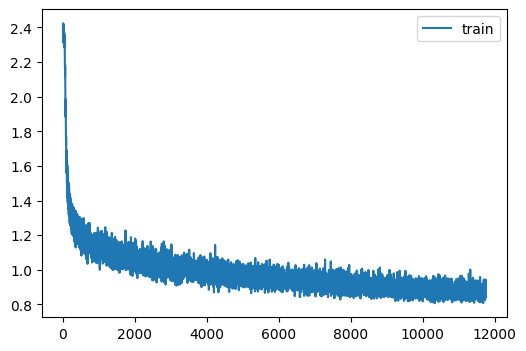

Fit 50 in: 1318.65s, setup: 0.00s, 25.61 ± 0.07s per epoch, 0.11 ± 0.00s per batch
Reseed: 1
Reseed: 1
TTA: 0.9555


In [14]:

learn = run(timm_model('resnet50d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                upscale32.bilinear(2),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.25)),
            train_cb=MixUpFP16CB(0.4, use_prev=True, label_smoothing=0.1),
            opt_func=partial(dadaptation.DAdaptAdam, weight_decay=0.0), base_lr=1,
            epochs=50, tta=True)

In [ ]:
save_model(learn, 'resnet50d_0.25')

In [11]:
save_model(learn, 'resnet50d_512_dadam')

### 95.66 bs 512

Reseed: 1
Batch size 512
Reseed: 1


accuracy,loss,epoch,train
0.377,1.920,0,train
0.778,0.647,0,eval
0.746,1.275,1,train
0.823,0.532,1,eval
0.785,1.181,2,train
0.847,0.485,2,eval
0.806,1.132,3,train
0.855,0.456,3,eval
0.814,1.111,4,train
0.886,0.400,4,eval


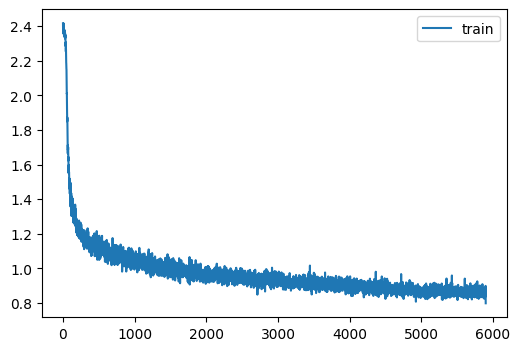

Fit 50 in: 925.72s, setup: 0.00s, 17.79 ± 0.14s per epoch, 0.15 ± 0.01s per batch
Reseed: 1
Reseed: 1
TTA: 0.9566


In [10]:
learn = run(timm_model('resnet50d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
               
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                upscale32.bilinear(2),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.2)),
            train_cb=MixUpFP16CB(0.4, use_prev=True, label_smoothing=0.1),
            opt_func=partial(dadaptation.DAdaptAdam, weight_decay=0.0), base_lr=1,
            epochs=50,bs=512, tta=True)

### 95.55 bs 512 seed205811062 dadapt

Reseed: 205811062
Batch size 512
Reseed: 205811062


accuracy,loss,epoch,train
0.388,1.919,0,train
0.775,0.642,0,eval
0.741,1.282,1,train
0.846,0.489,1,eval
0.786,1.181,2,train
0.870,0.425,2,eval
0.808,1.133,3,train
0.862,0.460,3,eval
0.811,1.119,4,train
0.874,0.440,4,eval


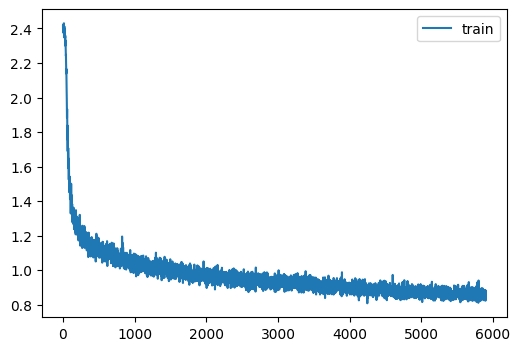

Fit 50 in: 926.14s, setup: 0.00s, 17.80 ± 0.06s per epoch, 0.15 ± 0.01s per batch
Reseed: 205811062
Reseed: 205811062
TTA: 0.9555


In [12]:
learn = run(timm_model('resnet50d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
               
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                upscale32.bilinear(2),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.2)),
            train_cb=MixUpFP16CB(0.4, use_prev=True, label_smoothing=0.1),
            opt_func=partial(dadaptation.DAdaptAdam, weight_decay=0.0), base_lr=1,
            epochs=50,bs=512, tta=True)

In [13]:
save_model(learn, 'resnet50d_512_dadam_ok')

### 0.9565 dropout 0.1 bs512 dadapt

Reseed: 1
Batch size 512
Reseed: 1


accuracy,loss,epoch,train
0.412,1.861,0,train
0.776,0.648,0,eval
0.756,1.248,1,train
0.842,0.507,1,eval
0.792,1.163,2,train
0.850,0.476,2,eval
0.809,1.120,3,train
0.859,0.459,3,eval
0.816,1.103,4,train
0.892,0.367,4,eval


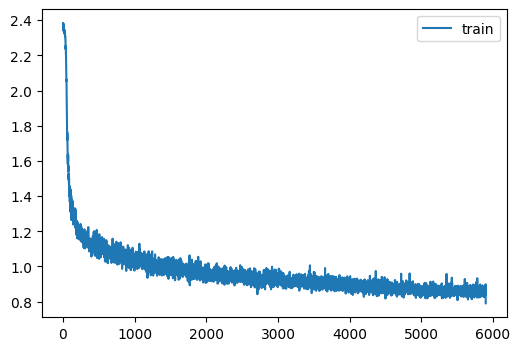

Fit 50 in: 925.98s, setup: 0.00s, 17.79 ± 0.03s per epoch, 0.15 ± 0.01s per batch
Reseed: 1
Reseed: 1
TTA: 0.9565


In [11]:
learn = run(timm_model('resnet50d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.1),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                upscale32.bilinear(2),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.2)),
            train_cb=MixUpFP16CB(0.4, use_prev=True, label_smoothing=0.1),
            opt_func=partial(dadaptation.DAdaptAdam, weight_decay=0.0), base_lr=1,
            epochs=50,bs=512, tta=True)

### 0.9573 dropout 0.1 bs384 dadapt

Reseed: 1
Batch size 384
Reseed: 1


accuracy,loss,epoch,train
0.483,1.749,0,train
0.782,0.646,0,eval
0.770,1.220,1,train
0.832,0.497,1,eval
0.797,1.153,2,train
0.870,0.466,2,eval
0.806,1.128,3,train
0.877,0.410,3,eval
0.817,1.094,4,train
0.895,0.379,4,eval


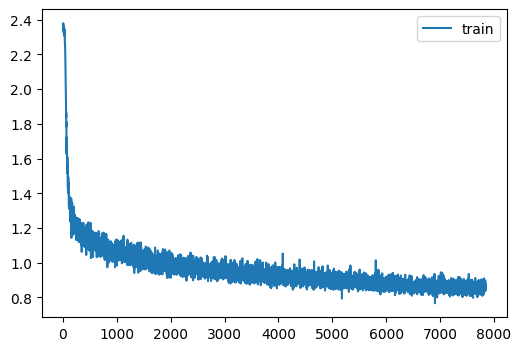

Fit 50 in: 1060.87s, setup: 0.00s, 20.46 ± 0.04s per epoch, 0.13 ± 0.00s per batch
Reseed: 1
Reseed: 1
TTA: 0.9573


In [12]:
learn = run(timm_model('resnet50d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.1),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                upscale32.bilinear(2),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.2)),
            train_cb=MixUpFP16CB(0.4, use_prev=True, label_smoothing=0.1),
            opt_func=partial(dadaptation.DAdaptAdam, weight_decay=0.0), base_lr=1,
            epochs=50,bs=384, tta=True)

In [13]:
save_model(learn, 'resnet50d-384')

### 0.9572 no dropout dadapt

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.559,1.605,0,train
0.834,0.512,0,eval
0.783,1.187,1,train
0.871,0.422,1,eval
0.804,1.129,2,train
0.868,0.420,2,eval
0.817,1.099,3,train
0.882,0.398,3,eval
0.823,1.083,4,train
0.879,0.449,4,eval


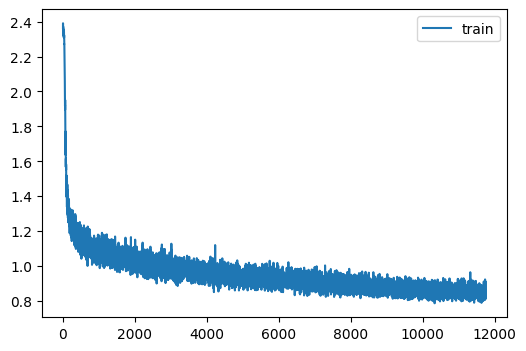

Fit 50 in: 1315.55s, setup: 0.00s, 25.55 ± 0.05s per epoch, 0.11 ± 0.00s per batch
Reseed: 1
Reseed: 1
TTA: 0.9572


In [14]:
learn = run(timm_model('resnet50d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.0),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                upscale32.bilinear(2),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.2)),
            train_cb=MixUpFP16CB(0.4, use_prev=True, label_smoothing=0.1),
            opt_func=partial(dadaptation.DAdaptAdam, weight_decay=0.0), base_lr=1,
            epochs=50,bs=256, tta=True)

### 0.9558 2x RandErase dadapt

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.538,1.646,0,train
0.818,0.537,0,eval
0.768,1.221,1,train
0.863,0.467,1,eval
0.786,1.168,2,train
0.860,0.457,2,eval
0.804,1.129,3,train
0.870,0.454,3,eval
0.811,1.113,4,train
0.883,0.404,4,eval


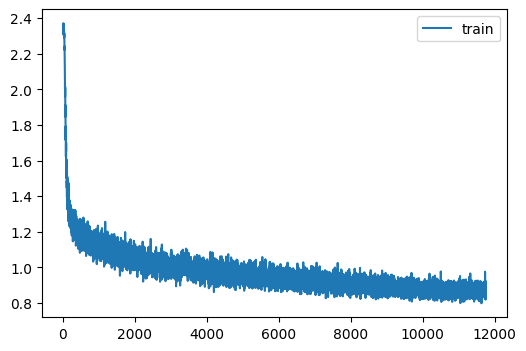

Fit 50 in: 1320.00s, setup: 0.00s, 25.64 ± 0.10s per epoch, 0.11 ± 0.00s per batch
Reseed: 1
Reseed: 1
TTA: 0.9558


In [15]:
learn = run(timm_model('resnet50d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.0),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                upscale32.bilinear(2),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.2),
                RandErase(pct=0.2)),
            train_cb=MixUpFP16CB(0.4, use_prev=True, label_smoothing=0.1),
            opt_func=partial(dadaptation.DAdaptAdam, weight_decay=0.0), base_lr=1,
            epochs=50,bs=256, tta=True)

# Export

In [7]:
import nbdev; nbdev.nbdev_export()